## Load all necessary libraries

In [231]:
import pandas as pd
import numpy as np
import seaborn as sb


## Data Processing

#### Load data and print head

In [232]:
data_train = pd.read_csv("data_train.csv")
print(data_train.head())

   Unnamed: 0  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0           0        797.0    -200.0       2.1          593.0    146.0   
1           1       1282.0    -200.0      11.0         1013.0    354.0   
2           2        891.0    -200.0       7.6          882.0    342.0   
3           3       1285.0    -200.0      18.1         1243.0    481.0   
4           4        892.0    -200.0       7.3          869.0     71.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1212.0     72.0         984.0        494.0  10.8  49.7  0.6429  
1         545.0    141.0        1384.0       1287.0  17.4  50.6  0.9989  
2         885.0    149.0         950.0        894.0   7.8  33.9  0.3594  
3         599.0    173.0        1815.0       1582.0  26.4  41.9  1.4237  
4         953.0     77.0        1363.0        632.0  37.4  14.7  0.9295  


This data contains various components of air quality data, some of which is measured by hourly averaged sensor response, the other parts are measured in microg/m^3, celcius for temperature, hourly averaged NOx concentration in ppb for NOx.

#### Find the number of missing rows

In [233]:
missing_values_column_list = data_train.isnull().sum()
#debug print
#print(missing_values_column_list)
total_missing_values = missing_values_column_list.sum()

# print the total number of missing values
print("Total number of missing values:", total_missing_values)

Total number of missing values: 924


#### Drop the missing rows

In [234]:
data_train.dropna(inplace=True)


#### Extract label and feature columns

In [235]:
# get list of column names
feature_columns = data_train.columns.tolist()
label_columns = data_train.columns.tolist()

# remove the label column and unnamed column from the list of feature names
feature_columns.remove('Unnamed: 0')
feature_columns.remove('PT08.S1(CO)')
features = data_train[feature_columns]

label_columns.remove('Unnamed: 0')
for feature_name in feature_columns:
    label_columns.remove(str(feature_name))
label = data_train[label_columns]
print(label.shape)
print(features.shape)


(6173, 1)
(6173, 11)


## Exploratory Data Analysis

#### Plot histograms

array([[<Axes: title={'center': 'NMHC(GT)'}>,
        <Axes: title={'center': 'C6H6(GT)'}>,
        <Axes: title={'center': 'PT08.S2(NMHC)'}>],
       [<Axes: title={'center': 'NOx(GT)'}>,
        <Axes: title={'center': 'PT08.S3(NOx)'}>,
        <Axes: title={'center': 'NO2(GT)'}>],
       [<Axes: title={'center': 'PT08.S4(NO2)'}>,
        <Axes: title={'center': 'PT08.S5(O3)'}>,
        <Axes: title={'center': 'T'}>],
       [<Axes: title={'center': 'RH'}>, <Axes: title={'center': 'AH'}>,
        <Axes: >]], dtype=object)

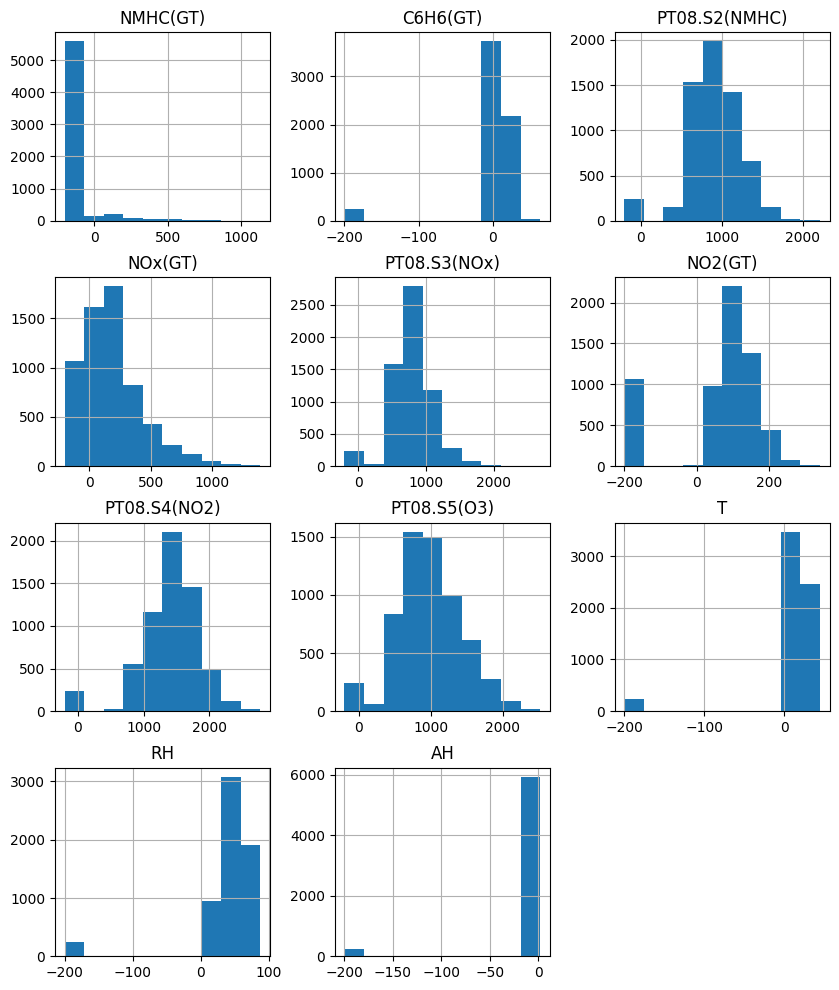

In [236]:
features[feature_columns].hist(figsize=(10, 12))


array([[<Axes: title={'center': 'NMHC(GT)'}>,
        <Axes: title={'center': 'C6H6(GT)'}>,
        <Axes: title={'center': 'PT08.S2(NMHC)'}>],
       [<Axes: title={'center': 'NOx(GT)'}>,
        <Axes: title={'center': 'PT08.S3(NOx)'}>,
        <Axes: title={'center': 'NO2(GT)'}>],
       [<Axes: title={'center': 'PT08.S4(NO2)'}>,
        <Axes: title={'center': 'PT08.S5(O3)'}>,
        <Axes: title={'center': 'T'}>],
       [<Axes: title={'center': 'RH'}>, <Axes: title={'center': 'AH'}>,
        <Axes: >]], dtype=object)

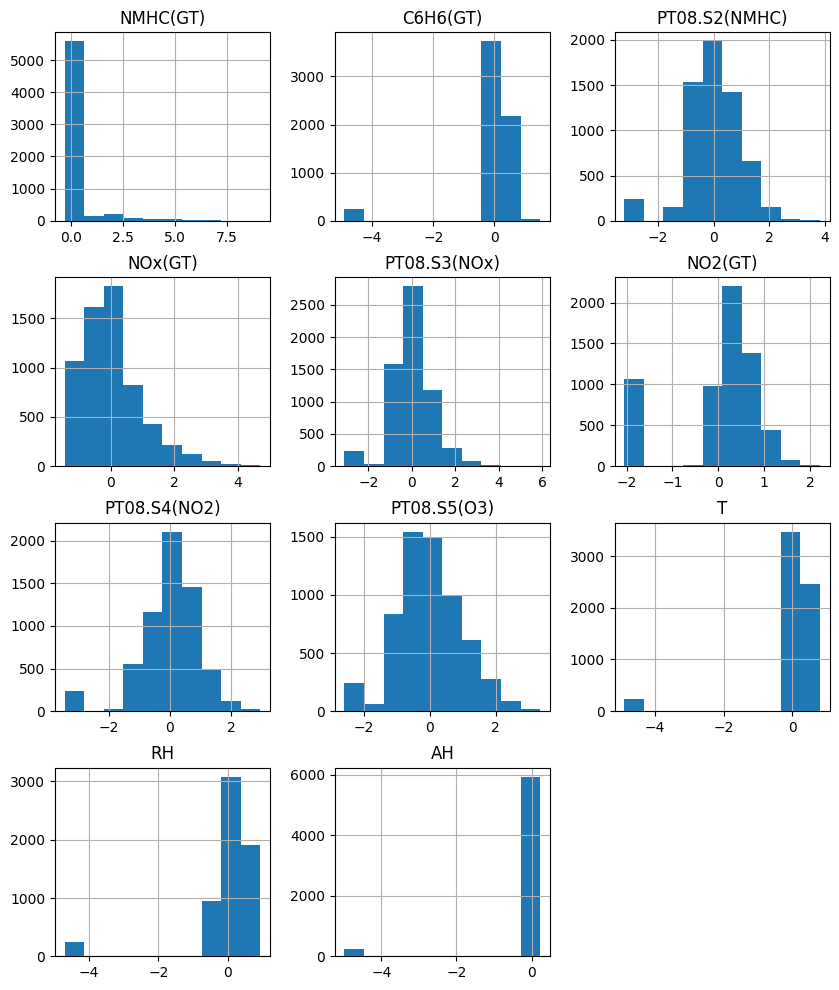

In [237]:

# Normalize features
norm_features = (features - features.mean()) / features.std()
norm_features[feature_columns].hist(figsize=(10, 12))


There are some outliers for sure but the larger issue is that if the numbers are so big then when updating the weights this will cause an overshoot so by normalizing the data we can avoid this and we can also adjust the scales that the data is on because they are all measured differently right now.

#### Scatter Plot

<Axes: xlabel='PT08.S4(NO2)', ylabel='PT08.S5(O3)'>

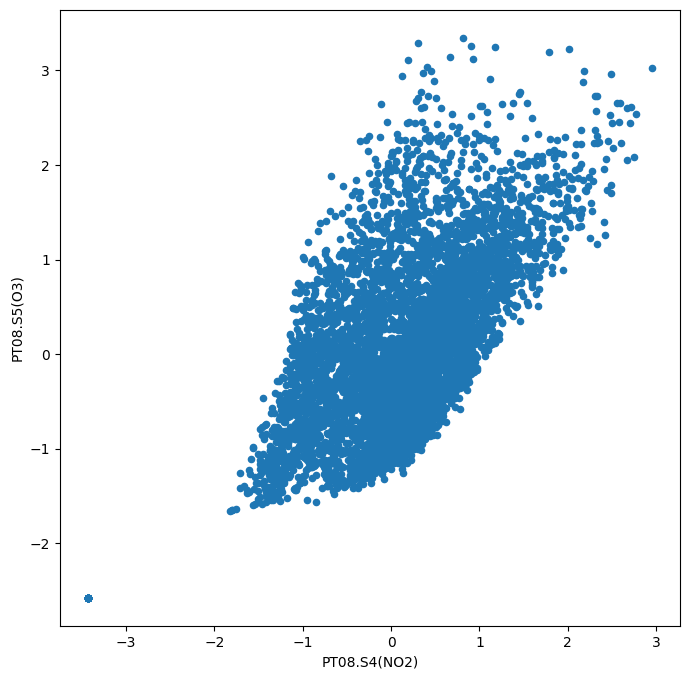

In [238]:
norm_features.plot(kind='scatter', x="PT08.S4(NO2)", y="PT08.S5(O3)", figsize=(8, 8))


I believe there is a pretty high correlation between these 2 features as if I were to draw a trendline I can basically see where it would go.

#### Pearson’s correlation

<Axes: >

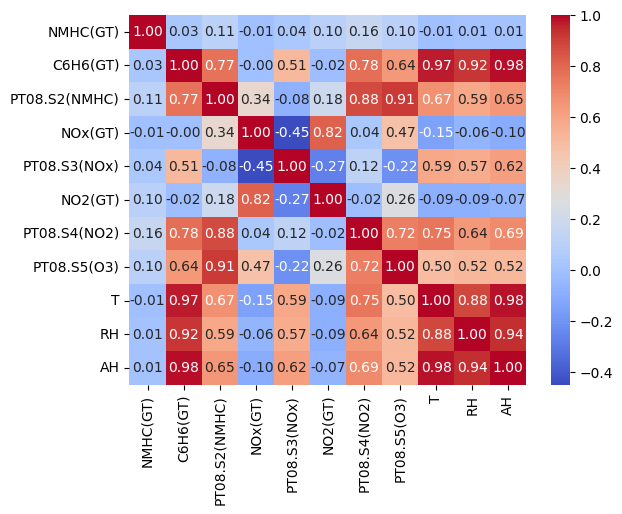

In [239]:
correlation = norm_features.corr()
sb.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")

There are some obvious correlations between temperature and humidity, the PTO8 family also seems to be correlated, but besides these 2 the rest of the correlations are far less obvious.

- NMHC - has no correlations
- C6H6 - has correlations with PTO8.S2, PTO8.S3, PTO8.S4 PTO8.S5, and the temp and humidity readings
- PT08.S2 - has correlations with C6H6, PTO8.S4, PTO8.S5, and the temp and humidity readings
- NOx - has correlations with NO2
- PTO8.S3 - has correlations with C6H6, and the temp and humidity readings
- NO2 - has correlations with NOx
- PTO8.S4 - has correlations with C6H6, PTO8.S2, PTO8.S5, and the temp and humidity readings
- PTO8.S5 - has correlations with C6H6, PTO8.S2, PTO8.S4, and the temp and humidity readings
- T - has correlations with C6H6, PTO8.S2, PTO8.S3, PTO8.S4, PTO8.S5, and the humidity readings
- RH - has correlations with C6H6, PTO8.S2, PTO8.S3, PTO8.S4, PTO8.S5, T, and the other humidity readings
- AH - has correlations with C6H6, PTO8.S2, PTO8.S3, PTO8.S4, PTO8.S5, T, and the other humidity readings

## Linear Regression Implementation

In [240]:
# transfer data from pandas to numpy
x = np.matrix(norm_features.values)
y = np.array(label.values)

# get size of dimensionality
sample_size, feature_size = x.shape
epoch_weight = 1 / sample_size

# Initialize weights
weights_arr = np.zeros((feature_size,1))
bias_term = 0

# Hyper params
learning_rate = .01
iterations = 10000

for epoch in range(0, iterations):
    # make prediction
    dot_prod_pred = np.dot(x, weights_arr)
    pred = bias_term + dot_prod_pred

    # calculate how much off
    total_diff = np.sum(pred - y)
    element_wise_diff = (pred - y)
    dot_prod_diff = np.dot(x.T, element_wise_diff)

    # multiply by weight of epoch
    bias_prop = epoch_weight * total_diff
    weight_prop = epoch_weight * dot_prod_diff

    # update the weights and bias by difference
    bias_term -= learning_rate * bias_prop
    weights_arr -= learning_rate * weight_prop


## Result Analysis

In [241]:
# setup rmse list for results to avg
rmse_vals = []

# start cross-validation
for fold in range(0,5):
    # Set the start and end for the validation set
    start = fold * (len(x) // 5)
    end = (fold + 1) * (len(x) // 5)

    # get validation data
    x_validation = x[start:end]
    y_validation = y[start:end]

    # get training data
    x_start_end = [x[:start], x[end:]]
    y_start_end = [y[:start], y[end:]]
    x_train_data = np.concatenate(x_start_end)
    y_train_data = np.concatenate(y_start_end)

    # Train the model
    # model.fit(X_train_fold, y_train_fold)
    fold_sample_size, fold_feature_size = x_train_data.shape
    fold_epoch_weight = 1 / fold_sample_size

    # Initialize weights
    fold_weights_arr = np.zeros((fold_feature_size,1))
    fold_bias_term = 0

    # Hyper params
    learning_rate = .01
    iterations = 10000

    for epoch in range(0, iterations):
        # make prediction
        fold_dot_prod_pred = np.dot(x_train_data, fold_weights_arr)
        fold_pred = fold_bias_term + fold_dot_prod_pred


        # calculate how much off
        fold_total_diff = np.sum(fold_pred - y_train_data)
        fold_element_wise_diff = (fold_pred - y_train_data)
        fold_dot_prod_diff = np.dot(x_train_data.T, fold_element_wise_diff)

        # multiply by weight of epoch
        fold_bias_prop = fold_epoch_weight * fold_total_diff
        fold_weight_prop = fold_epoch_weight * fold_dot_prod_diff


        # update the weights and bias by difference
        fold_bias_term -= learning_rate * fold_bias_prop
        fold_weights_arr -= learning_rate * fold_weight_prop

    # make predictions on the validation set
    fold_val_prediction = np.dot(x_validation , fold_weights_arr) + fold_bias_term



    # calculate how much off
    distance = (y_validation - fold_val_prediction)
    distance_squared = np.square(distance)

    # get rmse
    rmse = np.sqrt(np.mean(distance_squared))

    # add to list of rmse vals
    rmse_vals.append(rmse)

# find avg rmse vals
avg_rmse = np.mean(rmse_vals)

# find standard deviation of rmse vals
std_rmse = np.std(rmse_vals)

# output data
print("array of RMSE values:", rmse_vals)
print("average RMSE:", avg_rmse)
print("standard deviation of RMSE:", std_rmse)

array of RMSE values: [70.69830557401707, 72.7399015555389, 68.34514133958146, 72.72834633794716, 73.48605703286766]
average RMSE: 71.59955036799046
standard deviation of RMSE: 1.8728005164573134


There isn't a big change across the folds, the standard deviation is only 1.87 for the RMSE values. The weights or coefficients that are larger have a greater impact on the model so the features that those larger coefficients positive or negative belong to are the ones that correlate best with the targeted label.

## Inference

In [242]:
# load Data
data_test = pd.read_csv("data_test.csv")

# drop missing values
data_test.dropna(inplace=True)

# get the feature columns
test_feature_columns = data_test.columns.tolist()
test_feature_columns.remove('Unnamed: 0')
test_features = data_test[test_feature_columns]

# normalize the data
norm_test_features = (test_features - test_features.mean()) / test_features.std()
x_test = np.matrix(norm_test_features.values)

# make prediction
test_prediction = np.dot(x_test , weights_arr) + bias_term

# convert the matrix to a pandas dataframe
final_prediction = pd.DataFrame(test_prediction, columns=['pred_linear'])

# Save the dataframe to a CSV file
final_prediction.to_csv('output.csv', index=False)
